# Implementing Batch Gradient Descent with early stopping for Softmax Regression
__Author__ : Mohammad Rouintan , 400222042

__Course__ : Undergraduate Machine Learning Course

In [309]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Problem
Implement batch gradient descent with early stopping for softmax regression from scratch. Use it on a classification task on the Penguins dataset

### Softmax Regression
The Logistic Regression model can be generalized to support multiple classes directly, without having to train and combine multiple binary classifiers. This is called $Softmax Regression$, or $Multinomial Logistic Regression$.

The idea is quite simple: when given an instance $x$, the Softmax Regression model first computes a score $S_{k}(x)$ for each class $k$, then estimates the probability of each class by applying the softmax function (also called the normalized exponential) to the scores. The equation to compute $S_{k}(x)$ should look familiar, as it is just like the equation for Linear Regression prediction.

#### Softmax score for class k
$$
\begin{align}
S_{k}(x) &= (\theta^{(k)})^{T}x \tag{1}
\end{align}
$$

Note that each class has its own dedicated parameter vector $\theta^{(k)}$.All these vectors are typically stored as rows in a parameter matrix $\Theta$.

Once you have computed the score of every class for the instance $x$, you can estimate the probability $\hat{p}_{k}$ that the instance belongs to class $k$ by running the scores through the softmax function: it computes the exponential of every score, then normalizes them (dividing by the sum of all the exponentials).

#### Softmax function
$$
\begin{align}
\hat{p}_{k} &= \sigma(s(x))_{k} = \frac{e^{S_{k}(x)}}{\sum\limits_{j = 1}^{K} e^{S_{j}(x)}} \tag{2}
\end{align}
$$

1. $K$ is the number of classes.
2. $s(x)$ is a vector containing the scores of each class for instance $x$.
3. $\sigma(s(x))_{k}$ is the estimated probability that the instance $x$ belongs to class $k$ given the scores of each class for that instance.

Just like the Logistic Regression classifier, the Softmax Regression classifier predicts the class with the highest estimated probability (which is simply the class with the highest score)

#### Softmax Regression classifier prediction

$$
\begin{align}
\hat{y} = argmax \,\, \sigma(s(x))_{k} = argmax \,\, S_{k}(x) = argmax \,\, ((\theta^{(k)})^{T}x) \tag{3}
\end{align}
$$
The $argmax$ operator returns the value of a variable that maximizes a function. In this equation, it returns the value of $k$ that maximizes the estimated probability $\sigma(s(x))_{k}$.

Now that you know how the model estimates probabilities and makes predictions, let’s take a look at training. The objective is to have a model that estimates a high probability for the target class (and consequently a low probability for the other classes). Minimizing the cost function, called the cross entropy, should lead to this objective because it penalizes the model when it estimates a low probability for a target class. Cross entropy is frequently used to measure how well a set of estimated class probabilities match the target classes.

#### Cross entropy cost function
$$
\begin{align}
J(\Theta) = -\frac{1}{m} \sum\limits_{i = 1}^{m} \sum\limits_{k = 1}^{K} y_{k}^{(i)}\log(\hat{p}_{k}^{(i)}) \tag{4}
\end{align}
$$
$y_{k}^{(i)}$ is the target probability that the $i^{th}$ instance belongs to class $k$. In general, it is either equal to 1 or 0, depending on whether the instance belongs to the class or not.
Notice that when there are just two classes ($
K = 2$), this cost function is equivalent to the Logistic Regression’s cost function 

#### Cross entropy gradient vector for class k
$$
\nabla_{\theta^{(k)}} J(\Theta) = \frac{1}{m} \sum\limits_{i = 1}^{m} (\hat{p}_{k}^{(i)} - y_{k}^{(i)})x^{(i)} \tag{5}
$$
Now you can compute the gradient vector for every class, then use Gradient Descent (or any other optimization algorithm) to find the parameter matrix $\Theta$ that minimizes the cost function.

In [240]:
class SoftmaxRegression():
    def __init__(self, eta=0.01, epochs=50, l2=0.5):
        self.eta = eta
        self.epochs = epochs
        self.l2 = l2

    def one_hot(self, y, n_labels):
        y_one_hot = np.zeros((len(y), n_labels))
        y_one_hot[np.arange(len(y)), y] = 1
        return y_one_hot

    def soft_max(self, logits):
        numerator = np.exp(logits)
        denominator = np.sum(numerator, axis=1, keepdims=True)
        return numerator / denominator

    def cross_entropy(self, y_encoded, y_proba):
        return -np.mean(np.sum(y_encoded * np.log(y_proba), axis=1))

    def compute_gradient(self, X, y_encoded, y_proba):
        m = X.shape[0]
        dw = (1 / m) * np.dot(X.T, (y_proba - y_encoded))
        db = (1 / m) * np.sum(y_proba - y_encoded)
        return  dw, db

    def fit(self, X, y):
        self.n_classes = len(np.unique(y))
        print(self.n_classes)
        self.n_features = X.shape[1]
        self.bias = 0 
        self.weight = np.random.rand(self.n_features, self.n_classes)
        self.cost_ = []

        y_encoded = self.one_hot(y, self.n_classes)

        for epoch in range(self.epochs):
            logits = X.dot(self.weight) + self.bias
            softmax = self.soft_max(logits)
            cross_ent_loss = self.cross_entropy(y_encoded, softmax)
            l2_loss = self.l2 * np.sum(np.square(self.weight))
            loss = cross_ent_loss + 0.1 * l2_loss
            dw, db = self.compute_gradient(X, y_encoded, softmax)
            if epoch % 500 == 0:
                print(epoch, loss)
            self.weight -= self.eta * dw
            self.bias -= self.eta * db
            self.cost_.append(loss)

    def predict_proba(self, X):
        logits = X.dot(self.weight) + self.bias
        softmax = self.soft_max(logits)
        return softmax

    def predict(self, X):
        proba_predict = self.predict_proba(X)
        return proba_predict.argmax(axis=1)

### Test on iris data

In [264]:
from sklearn.datasets import load_iris
from mlxtend.plotting import plot_decision_regions
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

iris_X, iris_y = load_iris(return_X_y=True)
iris_X = iris_X[:, (0, 3)]
# standardize
iris_X[:,0] = (iris_X[:,0] - iris_X[:,0].mean()) / iris_X[:,0].std()
iris_X[:,1] = (iris_X[:,1] - iris_X[:,1].mean()) / iris_X[:,1].std()


x_train, x_test, y_train, y_test = train_test_split(iris_X, iris_y, test_size=0.2, random_state=42) 
#softmax_regression = make_pipeline(StandardScaler(), SoftmaxRegression(eta=0.1, epochs=5000))
softmax_regression = SoftmaxRegression(eta=0.01, epochs=100)


3
0 1.199431842510657
0.7666666666666667


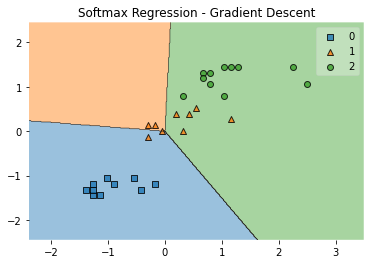

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2]


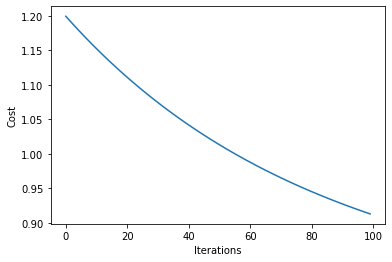

In [267]:
softmax_regression.fit(x_train, y_train)
y_pred = softmax_regression.predict(x_test)
accuracy_score = np.mean(y_pred == y_test)
print(accuracy_score)
plot_decision_regions(x_test, y_test, clf=softmax_regression)
plt.title('Softmax Regression - Gradient Descent')
plt.show()
plt.plot(range(len(softmax_regression.cost_)), softmax_regression.cost_)
plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.show()

### Test on Penguins data

In [279]:
penguins = pd.read_csv('Datasets/penguins.csv')
penguins.head(10)

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,MALE
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,FEMALE
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,FEMALE
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,FEMALE
5,Adelie,Torgersen,39.3,20.6,190.0,3650.0,MALE
6,Adelie,Torgersen,38.9,17.8,181.0,3625.0,FEMALE
7,Adelie,Torgersen,39.2,19.6,195.0,4675.0,MALE
8,Adelie,Torgersen,34.1,18.1,193.0,3475.0,NaN
9,Adelie,Torgersen,42.0,20.2,190.0,4250.0,NaN


In [281]:
penguins.dropna(axis=0, inplace=True)
penguins

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,MALE
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,FEMALE
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,FEMALE
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,FEMALE
5,Adelie,Torgersen,39.3,20.6,190.0,3650.0,MALE
...,...,...,...,...,...,...,...
338,Gentoo,Biscoe,47.2,13.7,214.0,4925.0,FEMALE
340,Gentoo,Biscoe,46.8,14.3,215.0,4850.0,FEMALE
341,Gentoo,Biscoe,50.4,15.7,222.0,5750.0,MALE
342,Gentoo,Biscoe,45.2,14.8,212.0,5200.0,FEMALE


In [296]:
from sklearn.preprocessing import OrdinalEncoder
ord_enc = OrdinalEncoder()
penguins_X = penguins[['bill_length_mm', 'bill_depth_mm']].values
penguins_y = penguins['species'].values
penguins_y = ord_enc.fit_transform(penguins_y.reshape(-1, 1)).astype(np.int32).squeeze()
x_train, x_test, y_train, y_test = train_test_split(penguins_X, penguins_y, test_size=0.2, random_state=40) 
softmax_regression = make_pipeline(StandardScaler(), SoftmaxRegression(eta=0.01, epochs=1000))

3
0 1.599391940274173
500 0.65211873298667
accuracy is 0.98507


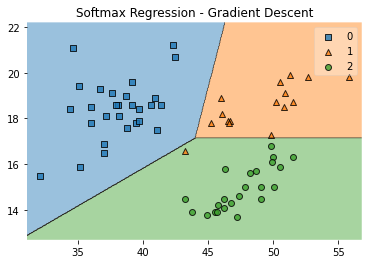

In [307]:
softmax_regression.fit(x_train, y_train)
y_pred = softmax_regression.predict(x_test)
accuracy_score = np.mean(y_pred == y_test)
print(f'accuracy is {accuracy_score:.5f}')
plot_decision_regions(x_test, y_test, clf=softmax_regression)
plt.title('Softmax Regression - Gradient Descent')
plt.show()

### Part b)
Description and code of second part

In [ ]:
# Your code for first problem

After each cell, you should explain your entire code. Please consider clean code in cells too and use comments if you should

## Conclusion for this problem
Write a conclusion and references which you've used in your homework